## The bABI project: automatic text understanding and reasoning

- Project info: Each sample contains a story (multiple sentences), several questions (single sentence) and answers. The goal is to let the machine learn and understand the story and make simple short answer (1 word) to a question.
- In this project, we focus on two types:
  - single supporting fact
  - two supporting facts 
- Approach: memory network
- Conclusion: The training is pretty fast for memory network and the prediction accuracy is very high.

In [1]:
# Disable warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import numpy as np
import re
import tarfile
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
from keras.utils.data_utils import get_file

/Users/yuanjing/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# download data from URL and open compressed tarfile
path = get_file(
    'babi-tasks-v1-2.tar.gz',
    origin = 'https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz'
)
tar = tarfile.open(path)

In [4]:
# Muliple datasets in tar file
# Only two will be used in this project
challenges = {
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
}

In [5]:
# define some util functions
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

def should_flatten(el):
    return not isinstance(el, (str, bytes))
def flatten(l):
    for el in l:
        if should_flatten(el):
            yield from flatten(el)
        else:
            yield el

In [6]:
def get_stories(f):    
    '''
    data contains a list of tuples:
    1. a story
    2. a question about the story
    3. the answer to the story
    '''
    data = []
    story = []
    for line in f:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)

        if int(nid) == 1:
            story = []

        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            story_so_far = [[str(i)] + s for i, s in enumerate(story) if s]
            data.append((story_so_far, q, a))
            story.append('')
        else:
            story.append(tokenize(line))
    return data

In [7]:
# Prepare inputs for model: Padding
# Pad sentences within story
# Pad stories so every story have the same number of sentences
def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
    '''
    pad sentences within story
    '''
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([[word2idx[w] for w in s] for s in story])
        queries.append([word2idx[w] for w in query])
        answers.append([word2idx[answer]])
    return (
        [pad_sequences(x, maxlen=story_maxlen) for x in inputs],
        pad_sequences(queries, maxlen=query_maxlen),
        np.array(answers)
  )

def stack_inputs(inputs, story_maxsents, story_maxlen):
    '''
    pad stories to have same number of sentences
    '''
    for i, story in enumerate(inputs):
        inputs[i] = np.concatenate(
          [
            story, 
            np.zeros((story_maxsents - story.shape[0], story_maxlen), 'int')
          ]
        )
    return np.stack(inputs)


In [8]:
def get_data(challenge_type):
    challenge = challenges[challenge_type]
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))

    stories = train_stories + test_stories
    
    story_maxlen = max((len(s) for x, _, _ in stories for s in x))
    story_maxsents = max((len(x) for x, _, _ in stories))
    query_maxlen = max(len(x) for _, x, _ in stories)

    vocab = sorted(set(flatten(stories)))
    vocab.insert(0, '<PAD>')
    vocab_size = len(vocab)

    word2idx = {c:i for i, c in enumerate(vocab)}

    inputs_train, queries_train, answers_train = vectorize_stories(
        train_stories, 
        word2idx,
        story_maxlen,
        query_maxlen
    )
    inputs_test, queries_test, answers_test = vectorize_stories(
        test_stories, 
        word2idx,
        story_maxlen,
        query_maxlen
    )

  
    inputs_train = stack_inputs(inputs_train, story_maxsents, story_maxlen)
    inputs_test = stack_inputs(inputs_test, story_maxsents, story_maxlen)
    print("inputs_train.shape: ", inputs_train.shape)
    print("inputs_test.shape: ", inputs_test.shape )
    return train_stories, test_stories, \
        inputs_train, queries_train, answers_train, \
        inputs_test, queries_test, answers_test, \
        story_maxsents, story_maxlen, query_maxlen, \
        vocab, vocab_size


## Single supporting fact

In [9]:
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('single_supporting_fact_10k')

/Users/yuanjing/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


inputs_train.shape:  (10000, 10, 8)
inputs_test.shape:  (1000, 10, 8)


###  Model building and training

In [10]:
embedding_dim = 15

# turn each story into a sequence of embedding vectors
# each story line is a vector "bag of words"
input_story_ = Input((story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
embedded_story = Lambda(lambda x: K.sum(x, axis=2))(embedded_story)
print("input story, input_story_.shape: ", input_story_.shape)
print("embedded story, embedded_story.shape: ", embedded_story.shape)

# turn questions into embedding
# different embedding from stories
input_question_ = Input((query_maxlen,))
embedded_question = Embedding(vocab_size, embedding_dim)(input_question_)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)
embedded_question = Reshape((1, embedding_dim))(embedded_question)

x = dot([embedded_story, embedded_question], 2)
x = Reshape((story_maxsents,))(x)
x = Activation('softmax')(x)
story_weights = Reshape((story_maxsents, 1))(x) 

input story, input_story_.shape:  (?, 10, 8)
embedded story, embedded_story.shape:  (?, 10, 15)


In [11]:
# Pass relevant sentence ( = weighted sentences) into dense layer with softmax
x = dot([story_weights, embedded_story], 1)
x = Reshape((embedding_dim,))(x)
ans = Dense(vocab_size, activation='softmax')(x)

model = Model([input_story_, input_question_], ans)
model.compile(
    optimizer = RMSprop(lr = 1e-2),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
r = model.fit(
    [inputs_train, queries_train],
    answers_train,
    epochs = 4,
    batch_size = 32,
    validation_data = ([inputs_test, queries_test], answers_test)
)

Train on 10000 samples, validate on 1000 samples
Epoch 1/4
10000/10000 [==============================] - 1s 98us/step - loss: 0.7304 - acc: 0.7559 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 2/4
10000/10000 [==============================] - 1s 86us/step - loss: 0.0103 - acc: 0.9976 - val_loss: 0.1011 - val_acc: 0.9750
Epoch 3/4
10000/10000 [==============================] - 1s 84us/step - loss: 0.0062 - acc: 0.9983 - val_loss: 0.0057 - val_acc: 0.9970
Epoch 4/4
10000/10000 [==============================] - 1s 83us/step - loss: 0.0067 - acc: 0.9989 - val_loss: 7.9686e-06 - val_acc: 1.0000


### Model testing

In [13]:
# Given a story, output weights that express the importance of each sentence for answering the question
debug_model = Model([input_story_, input_question_], story_weights)

In [14]:
# Check how sentences are weighted given a story and question
while True:   
    # randomly pick up a story
    story_idx = np.random.choice(len(train_stories))
    i = inputs_train[story_idx:story_idx+1]
    q = queries_train[story_idx:story_idx+1]
    w = debug_model.predict([i, q]).flatten()

    story, question, ans = train_stories[story_idx]  
    print("question:\n", " ".join(question))
    print("prediction: ", vocab[np.argmax(model.predict([i,q])[0])])
    print("answer: ", ans)
    print("story:")
    for i, line in enumerate(story):
        print("{:1.5f}".format(w[i]), "\t", " ".join(line))
    
    interact = input("Continue? [Y/n]")
    if interact and interact.lower().startswith('n'):
        break

question:
 Where is Daniel ?
prediction:  bathroom
answer:  bathroom
story:
0.00000 	 0 Daniel moved to the office .
0.00000 	 1 Daniel moved to the bedroom .
0.00000 	 3 Sandra went to the garden .
0.00058 	 4 Daniel went to the office .
0.00000 	 6 Sandra went to the office .
0.00000 	 7 Mary travelled to the hallway .
0.99940 	 9 Daniel went to the bathroom .
0.00001 	 10 Sandra went to the bathroom .
Continue? [Y/n]Y
question:
 Where is John ?
prediction:  bedroom
answer:  bedroom
story:
0.00000 	 0 Daniel moved to the bathroom .
0.99999 	 1 John journeyed to the bedroom .
Continue? [Y/n]Y
question:
 Where is Mary ?
prediction:  bathroom
answer:  bathroom
story:
0.00000 	 0 Daniel went to the garden .
0.00000 	 1 Daniel moved to the kitchen .
0.00000 	 3 John moved to the bedroom .
0.00922 	 4 Mary went to the bedroom .
0.00000 	 6 Daniel travelled to the hallway .
0.99078 	 7 Mary moved to the bathroom .
Continue? [Y/n]Y
question:
 Where is John ?
prediction:  garden
answer:  gard

## Two supporting facts

In [15]:
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('two_supporting_facts_10k')

/Users/yuanjing/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


inputs_train.shape:  (10000, 88, 8)
inputs_test.shape:  (1000, 88, 8)


### Model building and training

In [16]:
# two hops in model utilizing two facts
# output the answer from the 1st hop and serve as the new "question" in the second hop
# output the answer from the 2nd hop as the final anser
embedding = 30

def embed_and_sum(x, axis = 2):
    x = Embedding(vocab_size, embedding_dim)(x)
    x = Lambda(lambda x: K.sum(x, axis))(x)
    return x

input_story_ = Input((story_maxsents, story_maxlen))
input_question_ = Input((query_maxlen,))

embedded_story = embed_and_sum(input_story_)
embedded_question = embed_and_sum(input_question_, axis = 1)
dense_layer = Dense(embedding_dim, activation = 'elu')

def hop(query, story):
    x = Reshape((1, embedding_dim))(query)
    x = dot([story, x], 2)
    x = Reshape((story_maxsents,))(x)
    x = Activation('softmax')(x)
    story_weights = Reshape((story_maxsents, 1))(x)
    
    story_embedding2 = embed_and_sum(input_story_)
    x = dot([story_weights, story_embedding2], 1)
    x = Reshape((embedding_dim,))(x)
    x = dense_layer(x)
    return x, story_embedding2, story_weights


ans1, embedded_story, story_weights1 = hop(embedded_question, embedded_story)
ans2, _, story_weights2 = hop(ans1, embedded_story)
ans = Dense(vocab_size, activation = 'softmax')(ans2)

In [17]:
model2 = Model([input_story_, input_question_], ans)
model2.compile(
    optimizer = RMSprop(lr = 5e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [18]:
r = model2.fit(
    [inputs_train, queries_train],
    answers_train,
    epochs = 30,
    batch_size = 32,
    validation_data = ([inputs_test, queries_test], answers_test)
)

Train on 10000 samples, validate on 1000 samples
Epoch 1/30
10000/10000 [==============================] - 7s 688us/step - loss: 1.8294 - acc: 0.2186 - val_loss: 1.6283 - val_acc: 0.3430
Epoch 2/30
10000/10000 [==============================] - 7s 668us/step - loss: 1.5447 - acc: 0.3637 - val_loss: 1.4457 - val_acc: 0.3940
Epoch 3/30
10000/10000 [==============================] - 7s 669us/step - loss: 0.9601 - acc: 0.6339 - val_loss: 0.7338 - val_acc: 0.7250
Epoch 4/30
10000/10000 [==============================] - 6s 637us/step - loss: 0.6540 - acc: 0.7562 - val_loss: 0.6002 - val_acc: 0.7850
Epoch 5/30
10000/10000 [==============================] - 6s 649us/step - loss: 0.5591 - acc: 0.7926 - val_loss: 0.6018 - val_acc: 0.7760
Epoch 6/30
10000/10000 [==============================] - 7s 657us/step - loss: 0.5011 - acc: 0.8173 - val_loss: 0.5499 - val_acc: 0.8030
Epoch 7/30
10000/10000 [==============================] - 7s 670us/step - loss: 0.4485 - acc: 0.8397 - val_loss: 0.5334 - v

### Model testing

In [19]:
debug_model2 = Model(
    [input_story_, input_question_],
    [story_weights1, story_weights2]
)

In [20]:
while True:   
    # randomly pick up a story
    story_idx = np.random.choice(len(train_stories))
    i = inputs_train[story_idx:story_idx+1]
    q = queries_train[story_idx:story_idx+1]
    w1, w2 = debug_model2.predict([i, q])
    w1 = w1.flatten()
    w2 = w2.flatten()
    
    story, question, ans = train_stories[story_idx]  
    print("question:\n", " ".join(question))
    print("prediction: ", vocab[np.argmax(model2.predict([i,q])[0])])
    print("answer: ", ans)
    print("story:")
    for j, line in enumerate(story):
        print("{:1.5f}".format(w1[j]), "\t", "{:1.5f}".format(w2[j]), "\t", " ".join(line))
    
    interact = input("Continue? [Y/n]")
    if interact and interact.lower().startswith('n'):
        break



question:
 Where is the football ?
prediction:  bathroom
answer:  bathroom
story:
0.00000 	 0.00000 	 0 Sandra went back to the bathroom .
0.00000 	 0.00000 	 1 Mary went to the office .
0.00000 	 0.00000 	 2 John went back to the bedroom .
0.00000 	 0.00000 	 3 Sandra went to the garden .
0.00000 	 0.00000 	 4 Sandra moved to the bedroom .
0.00000 	 0.00000 	 5 John picked up the apple there .
0.00000 	 0.00000 	 6 John discarded the apple .
0.00000 	 0.00000 	 7 John travelled to the bathroom .
0.00000 	 0.00001 	 9 John went to the kitchen .
0.00000 	 0.00000 	 10 Sandra travelled to the garden .
0.00000 	 0.00000 	 12 Daniel went back to the bathroom .
0.00000 	 0.00000 	 13 Daniel went to the garden .
0.00000 	 0.00000 	 14 Daniel travelled to the kitchen .
0.00000 	 0.00000 	 15 Mary went back to the bedroom .
0.00000 	 0.00000 	 16 Mary went back to the garden .
0.00000 	 0.10388 	 17 John went back to the hallway .
1.00000 	 0.00000 	 18 John grabbed the football there .
0.0000

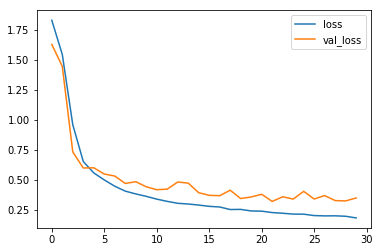

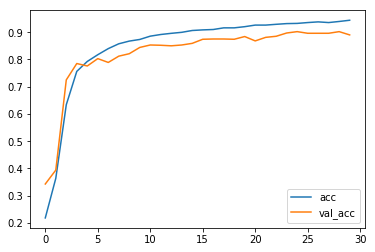

In [21]:
# visualize loss and accuracy
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()